通过多项式拟合来交互地探索这些概念

In [12]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用三阶多项式来生成训练和测试数据的标签

In [21]:
max_degree=20#多项式的最大阶数
n_train, n_test = 100, 100#训练和测试的数据集大小
true_w = np.zeros(max_degree)#分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [torch.tensor(x, dtype=d2l.float32) for x in [true_w, features,poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.4341],
         [-0.9344]]),
 tensor([[ 1.0000e+00,  4.3407e-01,  9.4210e-02,  1.3631e-02,  1.4793e-03,
           1.2842e-04,  9.2908e-06,  5.7613e-07,  3.1260e-08,  1.5077e-09,
           6.5445e-11,  2.5826e-12,  9.3419e-14,  3.1193e-15,  9.6714e-17,
           2.7987e-18,  7.5929e-20,  1.9388e-21,  4.6754e-23,  1.0681e-24],
         [ 1.0000e+00, -9.3445e-01,  4.3660e-01, -1.3599e-01,  3.1769e-02,
          -5.9373e-03,  9.2469e-04, -1.2344e-04,  1.4418e-05, -1.4970e-06,
           1.3989e-07, -1.1884e-08,  9.2538e-10, -6.6517e-11,  4.4397e-12,
          -2.7658e-13,  1.6153e-14, -8.8790e-16,  4.6094e-17, -2.2670e-18]]),
 tensor([5.2104, 1.6831]))

实现一个函数来评估模型在给定数据集上的损失

In [22]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上的模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数。

In [23]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())  

三阶多项式函数拟合(正态)

weight: [[ 5.002468   1.1997465 -3.387633   5.6095247]]


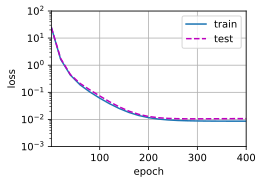

In [24]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])
#从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!

线性函数拟合(欠拟合)

weight: [[3.1708858 3.5991576]]


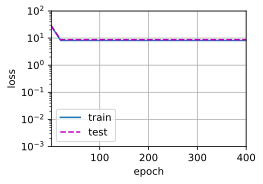

In [27]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])
# 从多项式特征中选择前2个维度，即 1, x

高阶多项式函数拟合(过拟合)

weight: [[ 4.987828    1.2769492  -3.3707805   5.177448    0.08203819  1.2740993
  -0.05601568  0.08397549  0.1963309   0.02075634 -0.11315578 -0.18713881
   0.19146189 -0.03663342 -0.10392057 -0.17055057 -0.09009529  0.10202426
   0.17323276  0.11678419]]


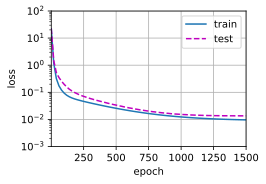

In [26]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)
# 从多项式特征中选取所有维度